# Final Model for C3 Euclidian Resorting

In [1]:
model_name = 'EEGNetTunerC3Euc_BDfiltered'

## Initialize

### Pip install amd import functions

In [2]:
import pickle
import numpy as np
import h5py
# mne imports
import mne
from mne import io
from mne.datasets import sample

# EEGNet-specific imports
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K

from keras.utils import custom_object_scope


# PyRiemann imports
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

# tools for plotting confusion matrices
from matplotlib import pyplot as plt

2024-06-10 15:26:29.747539: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-10 15:26:29.782772: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-10 15:26:29.782806: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-10 15:26:29.782823: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-10 15:26:29.789976: I tensorflow/core/platform/cpu_feature_g

In [3]:
def EEGNet(nb_classes, Chans = 64, Samples = 128, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    """ Keras Implementation of EEGNet
    http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta

    Note that this implements the newest version of EEGNet and NOT the earlier
    version (version v1 and v2 on arxiv). We strongly recommend using this
    architecture as it performs much better and has nicer properties than
    our earlier version. For example:
        
        1. Depthwise Convolutions to learn spatial filters within a 
        temporal convolution. The use of the depth_multiplier option maps 
        exactly to the number of spatial filters learned within a temporal
        filter. This matches the setup of algorithms like FBCSP which learn 
        spatial filters within each filter in a filter-bank. This also limits 
        the number of free parameters to fit when compared to a fully-connected
        convolution. 
        
        2. Separable Convolutions to learn how to optimally combine spatial
        filters across temporal bands. Separable Convolutions are Depthwise
        Convolutions followed by (1x1) Pointwise Convolutions. 
        
    
    While the original paper used Dropout, we found that SpatialDropout2D 
    sometimes produced slightly better results for classification of ERP 
    signals. However, SpatialDropout2D significantly reduced performance 
    on the Oscillatory dataset (SMR, BCI-IV Dataset 2A). We recommend using
    the default Dropout in most cases.
        
    Assumes the input signal is sampled at 128Hz. If you want to use this model
    for any other sampling rate you will need to modify the lengths of temporal
    kernels and average pooling size in blocks 1 and 2 as needed (double the 
    kernel lengths for double the sampling rate, etc). Note that we haven't 
    tested the model performance with this rule so this may not work well. 
    
    The model with default parameters gives the EEGNet-8,2 model as discussed
    in the paper. This model should do pretty well in general, although it is
	advised to do some model searching to get optimal performance on your
	particular dataset.

    We set F2 = F1 * D (number of input filters = number of output filters) for
    the SeparableConv2D layer. We haven't extensively tested other values of this
    parameter (say, F2 < F1 * D for compressed learning, and F2 > F1 * D for
    overcomplete). We believe the main parameters to focus on are F1 and D. 

    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.     
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D. 
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.

    """
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)


In [4]:
K.set_image_data_format('channels_last')

### Load data

In [5]:
import scipy.io

classes = scipy.io.loadmat("/mnt/d/sharegit/MasterThesis_data/TimeSeries/classes.mat")['classes']
ERPs = scipy.io.loadmat("/mnt/d/sharegit/MasterThesis_data/TimeSeries/ERPs.mat")['ERPs']

### Filter the data

In [29]:
import numpy as np
import scipy.signal as signal
import h5py
import time

batch_size = 100

def fir_filter(data, fs, lowcut, highcut, trans_width):
    nyquist = fs / 2
    numtaps = int(fs * 1)  # Reduce the length of the filter (1 second long)
    edges = [0, lowcut - trans_width, lowcut, highcut, highcut + trans_width, nyquist]
    taps = signal.firwin2(numtaps, edges, [0, 0, 1, 1, 0, 0], nyq=nyquist)
    filtered_data = signal.filtfilt(taps, 1.0, data)
    return filtered_data

def downsample(data, original_fs, target_fs):
    num_samples = int(len(data) * target_fs / original_fs)
    downsampled_data = signal.resample(data, num_samples)
    return downsampled_data

def process_batches(X, batch_size, output_path):
    num_channels = 22
    original_fs = 250
    target_fs = 100
    
    num_trials, num_channels, num_samples = X.shape
    num_downsampled_samples = int(num_samples * target_fs / original_fs)

    with h5py.File(output_path, 'w') as f:
        all_filtered = f.create_dataset('filtered', (num_trials, num_channels, num_downsampled_samples), dtype='float32')

        for start in range(0, num_trials, batch_size):
            end = min(start + batch_size, num_trials)
            batch_start_time = time.time()  # Start timing the batch processing
            for channel in range(num_channels):
                print(f"\rProcessing trials {end}/{num_trials}\t- chans = {channel+1}/{num_channels}\t - ", end="")
                eeg_signal = X[start:end, channel, :]

                # Apply FIR filter
                filtered_signal = np.apply_along_axis(fir_filter, 1, eeg_signal, original_fs, 4, 48, 1)
                
                # Downsample the signal
                downsampled_signal = np.apply_along_axis(downsample, 1, filtered_signal, original_fs, target_fs)
                
                all_filtered[start:end, channel, :] = downsampled_signal

            batch_end_time = time.time()  # End timing the batch processing
            batch_duration = batch_end_time - batch_start_time
            print(f"Batch processing time: {batch_duration:.2f} seconds")
        print(f"\n", end="")
    return output_path

# Path to save the HDF5 file
output_path = '/mnt/d/sharegit/MasterThesis_data/BDFilteredData.h5'

# Process the data in batches and save to HDF5 file
filtered_file = process_batches(X, batch_size, output_path)

Processing trials 100/7548	- chans = 22/22	 - Batch processing time: 7.41 seconds
Processing trials 200/7548	- chans = 22/22	 - Batch processing time: 6.12 seconds
Processing trials 300/7548	- chans = 22/22	 - Batch processing time: 6.14 seconds
Processing trials 400/7548	- chans = 22/22	 - Batch processing time: 6.31 seconds
Processing trials 500/7548	- chans = 22/22	 - Batch processing time: 6.18 seconds
Processing trials 600/7548	- chans = 22/22	 - Batch processing time: 7.50 seconds
Processing trials 700/7548	- chans = 22/22	 - Batch processing time: 6.29 seconds
Processing trials 800/7548	- chans = 22/22	 - Batch processing time: 8.94 seconds
Processing trials 900/7548	- chans = 22/22	 - Batch processing time: 6.42 seconds
Processing trials 1000/7548	- chans = 22/22	 - Batch processing time: 7.50 seconds
Processing trials 1100/7548	- chans = 22/22	 - Batch processing time: 6.37 seconds
Processing trials 1200/7548	- chans = 22/22	 - Batch processing time: 6.46 seconds
Processing tr

In [31]:
classes = scipy.io.loadmat("/mnt/d/sharegit/MasterThesis_data/TimeSeries/classes.mat")['classes']
imfs_file = '/mnt/d/sharegit/MasterThesis_data/BDFilteredData.h5'

# To load the data from the HDF5 file
with h5py.File(imfs_file, 'r') as f:
    X = f['filtered'][:]

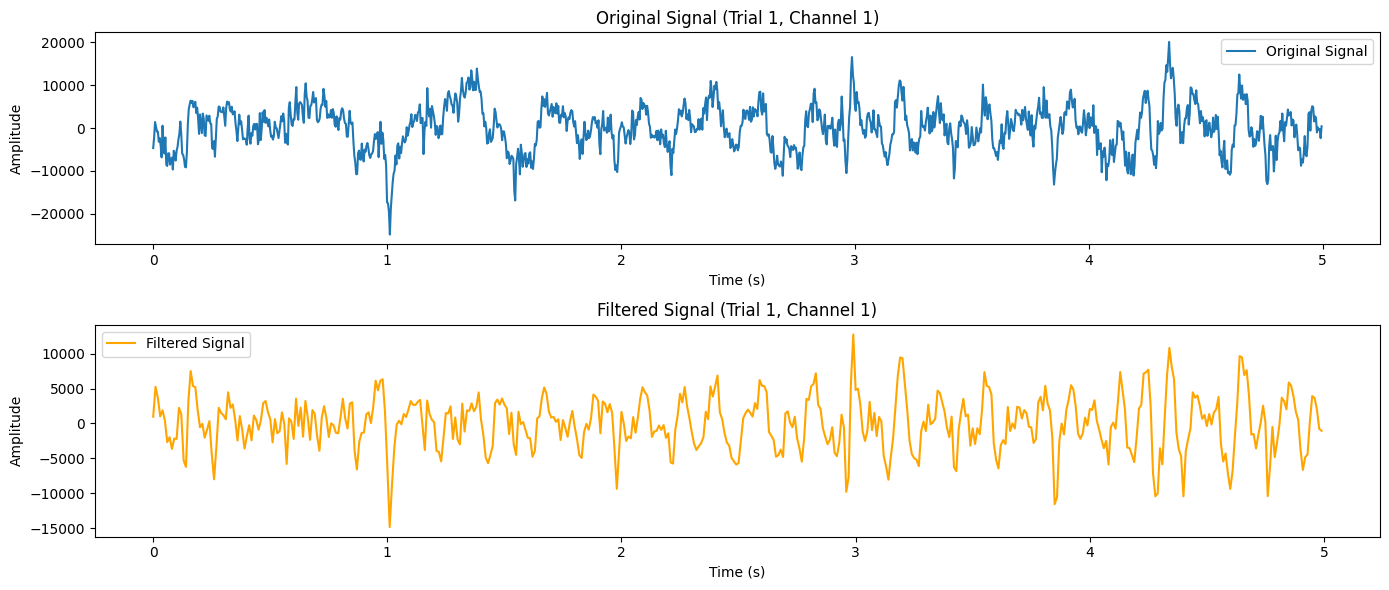

In [25]:
import matplotlib.pyplot as plt

# Assuming X and X_f are already defined and contain the original and filtered signals
# Example shapes: X.shape = (num_trials, num_channels, num_samples)
#                 X_f.shape = (num_trials, num_channels, num_samples)

# Select the trial and channel to plot
trial = 1
channel = 1

# Extract the signals
original_signal = X[trial, channel, :]
filtered_signal = X_f[trial, channel, :]

# Define the sampling frequencies
original_fs = 250  # Original sampling frequency
filtered_fs = 100  # Filtered (and downsampled) sampling frequency

# Create time vectors for plotting
original_time = np.arange(len(original_signal)) / original_fs
filtered_time = np.arange(len(filtered_signal)) / filtered_fs

# Plot the signals
plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(original_time, original_signal, label='Original Signal')
plt.title(f'Original Signal (Trial {trial}, Channel {channel})')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(filtered_time, filtered_signal, label='Filtered Signal', color='orange')
plt.title(f'Filtered Signal (Trial {trial}, Channel {channel})')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()


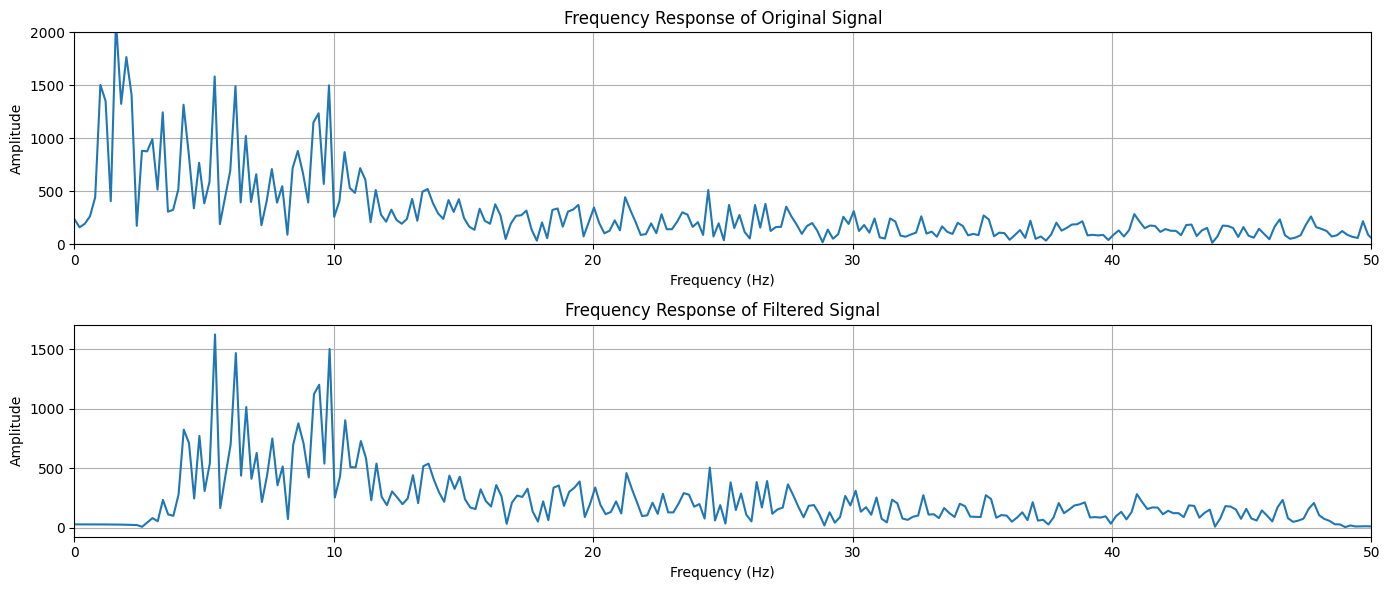

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft

# Function to plot the frequency response
def plot_frequency_response(signal, fs, title):
    N = len(signal)
    T = 1.0 / fs
    yf = fft(signal)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
    plt.grid()
    plt.title(title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')

# Sampling frequencies
original_fs = 250  # Original sampling frequency
filtered_fs = 100  # Filtered (and downsampled) sampling frequency

# Extract the signals
original_signal = X[1, 1, :]
filtered_signal = X_f[1, 1, :]

# Plot the frequency response
plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plot_frequency_response(original_signal, original_fs, 'Frequency Response of Original Signal')
plt.xlim((0,50))
plt.ylim((0,2000))

plt.subplot(2, 1, 2)
plot_frequency_response(filtered_signal, filtered_fs, 'Frequency Response of Filtered Signal')
plt.xlim((0,50))

plt.tight_layout()
plt.show()


### Prepare the data

In [6]:
classes = scipy.io.loadmat("/mnt/d/sharegit/MasterThesis_data/TimeSeries/classes.mat")['classes']
imfs_file = '/mnt/d/sharegit/MasterThesis_data/BDFilteredData.h5'

# To load the data from the HDF5 file
with h5py.File(imfs_file, 'r') as f:
    X = f['filtered'][:]
y = classes.T[0].copy()

In [7]:
# Use a smaller subset for testing (comment this out once the issue is resolved)
print(f'X shape: {X.shape}, X dtype: {X.dtype}')
print(f'y shape: {y.shape}, y dtype: {y.dtype}')

X shape: (7548, 22, 500), X dtype: float32
y shape: (7548,), y dtype: uint8


In [8]:
# Define your 2D grid dimensions
grid_x, grid_y = 5, 5  # Assuming a 5x5 grid based on the images provided

# Initialize a new array with an extra dimension for the 3D grid
X_3D = np.zeros((X.shape[0], grid_x, grid_y, X.shape[2]))

channel_indices = {
    0: 1,  # 'FP2'
    1: 11,  # 'F8'
    2: 19,  # 'AFz'
    3: 3,  # 'F4'
    4: 10,  # 'F7'
    5: 0,  # 'FP1'
    6: 16,  # 'FZ'
    7: 12,  # 'T7'
    8: 2,  # 'F3'
    9: 4,  # 'C3'
    10: 6,  # 'P3'
    11: 17,  # 'CZ'
    12: 14,  # 'P7'
    13: 8,  # 'O1'
    14: 20,  # 'CPZ'
    15: 18,  # 'PZ'
    16: 5,  # 'C4'
    17: 21,  # 'POZ'
    18: 7,  # 'P4'
    19: 13,  # 'T8'
    20: 9,  # 'O2'
    21: 15  # 'P8'
}

X_re = X.copy()
# Iterate over each trial and channel to populate the 3D grid
#for trial in range(X.shape[0]):
for ch_idx, ch_idx_reorder in channel_indices.items():
    # Assign the channel data to the correct location in the grid
    X_re[:,ch_idx,:]= X[:, ch_idx_reorder, :]

In [9]:
from sklearn.model_selection import train_test_split

mod = [1,1,1,1,2,2,2,2,3,3,3,3]
for i, replacement in enumerate(mod, start=1):
    y[classes.T[0] == i] = replacement


# Split the data into 50% training and 50% temp (which will later be split into test and validation)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.5, random_state=42)

# Split the temp data into 50% test and 50% validation, resulting in 25% of the original data each
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print(y_train)
num_classess = len(set(y_train))
print(f'There are {num_classess} unique classes in the dataset')

[1 2 2 ... 3 1 3]
There are 3 unique classes in the dataset


In [10]:
from collections import Counter

# the syntax is {class_1:weight_1, class_2:weight_2,...}. Here just setting
# the weights all to be 1
# Count the occurrences of each class
counts = Counter(y)

# Calculate the total number of samples
total_samples = sum(counts.values())

# Number of classes
num_classes = len(counts)

# Calculate class weights
class_weights = {class_label-1: total_samples / (num_classes * count) for class_label, count in counts.items()}
#class_weights = {0:1, 1:1, 2:1}
print(class_weights)

{0: 1.1282511210762332, 1: 0.9469326307866014, 2: 0.9455092070650132}


In [11]:
kernels, chans, samples = 1, 22, 500


# convert labels to one-hot encodings.
y_train      = np_utils.to_categorical(y_train-1)
y_val   = np_utils.to_categorical(y_val-1)
y_test       = np_utils.to_categorical(y_test-1)
print(y_train)
# convert data to NHWC (trials, channels, samples, kernels) format. Data
X_train      = X_train.reshape(X_train.shape[0], chans, samples, kernels)
X_val   = X_val.reshape(X_val.shape[0], chans, samples, kernels)
X_test       = X_test.reshape(X_test.shape[0], chans, samples, kernels)

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')


[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]
X_train shape: (3774, 22, 500, 1)
3774 train samples
1887 test samples


## Implement EEGNET without Hyperparameters

### Compile model

In [59]:
model = EEGNet(nb_classes = num_classess, Chans = chans, Samples = samples,
               dropoutRate = 0.5, kernLength = 32, F1 = 8, D = 2, F2 = 16,
               dropoutType = 'Dropout')

# compile the model and set the optimizers
model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics = ['accuracy'])
# count number of parameters in the model
numParams    = model.count_params()

model.summary()

2024-06-09 23:58:04.039540: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-09 23:58:04.238507: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-09 23:58:04.238560: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-09 23:58:04.242284: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-09 23:58:04.242325: I tensorflow/compile

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 22, 500, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 22, 500, 8)        256       
                                                                 
 batch_normalization (Batch  (None, 22, 500, 8)        32        
 Normalization)                                                  
                                                                 
 depthwise_conv2d (Depthwis  (None, 1, 500, 16)        352       
 eConv2D)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 1, 500, 16)        64        
 chNormalization)                                                
                                                             

ead NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-09 23:58:04.365627: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13553 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


### Train model

In [60]:
from tensorflow.keras.callbacks import ModelCheckpoint

# set a valid path for your system to record model checkpoints
checkpoint_path= '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/checkpoint.h5'
checkpointer = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_best_only=True)

# load optimal weights
#model.load_weights('checkpoint_ACC65p_3class.keras', by_name=True, skip_mismatch=True)
fittedModel = model.fit(X_train, y_train, batch_size = 16, epochs = 1000,
                        verbose = 2, validation_data=(X_val, y_val),
                        callbacks=checkpointer, class_weight = class_weights)

Epoch 1/1000


2024-06-09 23:58:11.687101: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-06-09 23:58:11.793916: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902
2024-06-09 23:58:11.948013: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-09 23:58:12.343447: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-09 23:58:12.798661: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f04280463e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-09 23:58:12.798690: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti SUPER, Compu


Epoch 1: val_loss improved from inf to 1.09304, saving model to /mnt/d/sharegit/MasterThesis_data/EEGNetTunerC3Euc_BDfiltered/checkpoint.h5
236/236 - 4s - loss: 1.0997 - accuracy: 0.3535 - val_loss: 1.0930 - val_accuracy: 0.4012 - 4s/epoch - 19ms/step
Epoch 2/1000


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 1.09304 to 1.08677, saving model to /mnt/d/sharegit/MasterThesis_data/EEGNetTunerC3Euc_BDfiltered/checkpoint.h5
236/236 - 2s - loss: 1.0866 - accuracy: 0.3810 - val_loss: 1.0868 - val_accuracy: 0.3911 - 2s/epoch - 7ms/step
Epoch 3/1000

Epoch 3: val_loss improved from 1.08677 to 1.08213, saving model to /mnt/d/sharegit/MasterThesis_data/EEGNetTunerC3Euc_BDfiltered/checkpoint.h5
236/236 - 2s - loss: 1.0775 - accuracy: 0.3983 - val_loss: 1.0821 - val_accuracy: 0.3937 - 2s/epoch - 8ms/step
Epoch 4/1000

Epoch 4: val_loss improved from 1.08213 to 1.07331, saving model to /mnt/d/sharegit/MasterThesis_data/EEGNetTunerC3Euc_BDfiltered/checkpoint.h5
236/236 - 2s - loss: 1.0788 - accuracy: 0.3996 - val_loss: 1.0733 - val_accuracy: 0.4197 - 2s/epoch - 7ms/step
Epoch 5/1000

Epoch 5: val_loss improved from 1.07331 to 1.06759, saving model to /mnt/d/sharegit/MasterThesis_data/EEGNetTunerC3Euc_BDfiltered/checkpoint.h5
236/236 - 2s - loss: 1.0720 - accuracy: 0.4192 -

### Save parameters

In [61]:
filepath = '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/modelFitted.pkl'

# Open the file in write-binary mode and dump the variables
with open(filepath, 'wb') as f:
    pickle.dump({'fittedModel': fittedModel, 'model': model}, f)

## EEGNET with Hyperparameters

### Define model and train using random search

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorboard.plugins.hparams import api as hp
import numpy as np
import scipy.io
import os
from PIL import Image
from keras_tuner.tuners import GridSearch, RandomSearch, Hyperband, BayesianOptimization

from keras.utils import get_custom_objects
from keras.optimizers import AdamW

In [13]:
def build_model(hp):
    get_custom_objects().update({'AdamW': AdamW})
    nb_classes = 3
    kernels, Chans, Samples = 1, 22, 500

    kernLength = hp.Int(f'kernLength', 32, 256, step = 32) # 32,
    F1 = hp.Int(f'F1', 6, 12, step = 2)
    D = hp.Int(f'D', 2, 8, step = 1)
    dropoutRate = hp.Float(f'dropoutRate', 0, 0.7, step = 0.2)
    F2 = hp.Int(f'F2', 16, 32, step = 4)
    norm_rate = 0.25
    opt = hp.Choice(f'optimizer', ['adam', 'AdamW'])
    dropoutType = hp.Choice('dropoutType',['Dropout', 'SpatialDropout2D'] )

    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')

    input1   = Input(shape = (Chans, Samples, 1))
    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False,
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)

    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)

    flatten      = Flatten(name = 'flatten')(block2)

    dense        = Dense(nb_classes, name = 'dense',
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)

    model = Model(inputs=input1, outputs=softmax)

    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    #model.load_weights('/content/drive/MyDrive/NNcodes/Checkpoints/checkpoint_ACC65p_3class_1000epocs.keras', by_name=True, skip_mismatch=True)

    return model

### Train RandomSearch

In [14]:
tuner_rs = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=300,
    executions_per_trial=1,
    directory='/mnt/d/sharegit/MasterThesis_data/'+ model_name +'/logs/rs',
    project_name='EEGNetTunerC3Euc',
    overwrite=False
)

tuner_rs.search(X_train, y_train, epochs=20, validation_data=(X_val, y_val), class_weight = class_weights,
             callbacks=[keras.callbacks.TensorBoard('/mnt/d/sharegit/MasterThesis_data/'+ model_name +'/logs/rs/rs_logs')])

Trial 300 Complete [00h 00m 54s]
val_accuracy: 0.527292013168335

Best val_accuracy So Far: 0.5882353186607361
Total elapsed time: 14h 43m 49s


### Visualize Results using Tensorboard

In [15]:
%reload_ext tensorboard

In [16]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [18]:
%tensorboard --logdir /mnt/d/sharegit/MasterThesis_data/EEGNetTunerC3Euc_BDfiltered/logs/rs/rs_logs

Reusing TensorBoard on port 6006 (pid 156263), started 0:00:48 ago. (Use '!kill 156263' to kill it.)

## Train using hyperparameters

### Compile model

In [12]:
model = EEGNet(nb_classes = num_classess, Chans = chans, Samples = samples,
               dropoutRate = 0.2, kernLength = 64, F1 = 10, D = 8, F2 = 16,
               dropoutType = 'Dropout')

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# count number of parameters in the model
model.count_params()

model.summary()

2024-06-10 15:26:48.070773: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 22, 500, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 22, 500, 10)       640       
                                                                 
 batch_normalization (Batch  (None, 22, 500, 10)       40        
 Normalization)                                                  
                                                                 
 depthwise_conv2d (Depthwis  (None, 1, 500, 80)        1760      
 eConv2D)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 1, 500, 80)        320       
 chNormalization)                                                
                                                             

2024-06-10 15:26:48.131742: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-10 15:26:48.131788: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-10 15:26:48.135097: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-10 15:26:48.135159: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-10 15:26:48.135192: I tensorflow/compile

### Train model

In [13]:
# set a valid path for your system to record model checkpoints
checkpointer = ModelCheckpoint(filepath='/mnt/d/sharegit/MasterThesis_data/' + model_name + '/checkpoint_hyperparam.h5', verbose=1,   save_best_only=True)

# load optimal weights
#model.load_weights('checkpoint_ACC65p_3class.keras', by_name=True, skip_mismatch=True)
fittedModel = model.fit(X_train, y_train, batch_size = 16, epochs = 1000,
                        verbose = 2, validation_data=(X_val, y_val),
                        callbacks=[checkpointer], class_weight = class_weights)

Epoch 1/1000


2024-06-10 15:26:49.365771: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-06-10 15:26:49.483938: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902
2024-06-10 15:26:49.625197: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-10 15:26:49.903466: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-10 15:26:50.326507: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f33b047f900 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-10 15:26:50.326534: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti SUPER, Compu


Epoch 1: val_loss improved from inf to 1.08303, saving model to /mnt/d/sharegit/MasterThesis_data/EEGNetTunerC3Euc_BDfiltered/checkpoint_hyperparam.h5
236/236 - 4s - loss: 1.0896 - accuracy: 0.3702 - val_loss: 1.0830 - val_accuracy: 0.3906 - 4s/epoch - 17ms/step
Epoch 2/1000


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 1.08303 to 1.06149, saving model to /mnt/d/sharegit/MasterThesis_data/EEGNetTunerC3Euc_BDfiltered/checkpoint_hyperparam.h5
236/236 - 2s - loss: 1.0639 - accuracy: 0.4187 - val_loss: 1.0615 - val_accuracy: 0.4155 - 2s/epoch - 7ms/step
Epoch 3/1000

Epoch 3: val_loss improved from 1.06149 to 1.04018, saving model to /mnt/d/sharegit/MasterThesis_data/EEGNetTunerC3Euc_BDfiltered/checkpoint_hyperparam.h5
236/236 - 2s - loss: 1.0440 - accuracy: 0.4494 - val_loss: 1.0402 - val_accuracy: 0.4584 - 2s/epoch - 7ms/step
Epoch 4/1000

Epoch 4: val_loss improved from 1.04018 to 1.03183, saving model to /mnt/d/sharegit/MasterThesis_data/EEGNetTunerC3Euc_BDfiltered/checkpoint_hyperparam.h5
236/236 - 2s - loss: 1.0129 - accuracy: 0.4828 - val_loss: 1.0318 - val_accuracy: 0.4780 - 2s/epoch - 7ms/step
Epoch 5/1000

Epoch 5: val_loss improved from 1.03183 to 0.99561, saving model to /mnt/d/sharegit/MasterThesis_data/EEGNetTunerC3Euc_BDfiltered/checkpoint_hyperparam.h5
236/

### Save model results

In [14]:
filepath = '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/modelFittedHyperParam.pkl'

# Open the file in write-binary mode and dump the variables
with open(filepath, 'wb') as f:
    pickle.dump({'fittedModel': fittedModel, 'model': model}, f)


## Assessment

### Accuracy evaluation both methods

In [15]:
# Replace 'your_file.pkl' with the path to your pickle file
filepath = '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/modelFitted.pkl'

with open(filepath, 'rb') as f:
    data = pickle.load(f)

fittedModel = data['fittedModel']
model = data['model']

# load optimal weights
model.load_weights('/mnt/d/sharegit/MasterThesis_data/' + model_name + '/checkpoint.h5')

probs       = model.predict(X_test)
preds       = probs.argmax(axis = -1)
acc         = np.mean(preds == y_test.argmax(axis=-1))
print("Classification accuracy: %f " % (acc))

59/59 [==============================] - 0s 3ms/step
Classification accuracy: 0.633810 


In [16]:
# Replace 'your_file.pkl' with the path to your pickle file
filepath = '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/modelFittedHyperParam.pkl'

with open(filepath, 'rb') as f:
    data = pickle.load(f)

fittedModel_hp = data['fittedModel']
model_hp = data['model']

# load optimal weights
model_hp.load_weights('/mnt/d/sharegit/MasterThesis_data/' + model_name + '/checkpoint_hyperparam.h5')

probs       = model_hp.predict(X_test)
preds_hp       = probs.argmax(axis = -1)
acc         = np.mean(preds == y_test.argmax(axis=-1))
print("Classification Hyperparameter model accuracy: %f " % (acc))

59/59 [==============================] - 0s 2ms/step
Classification Hyperparameter model accuracy: 0.633810 


### Performance

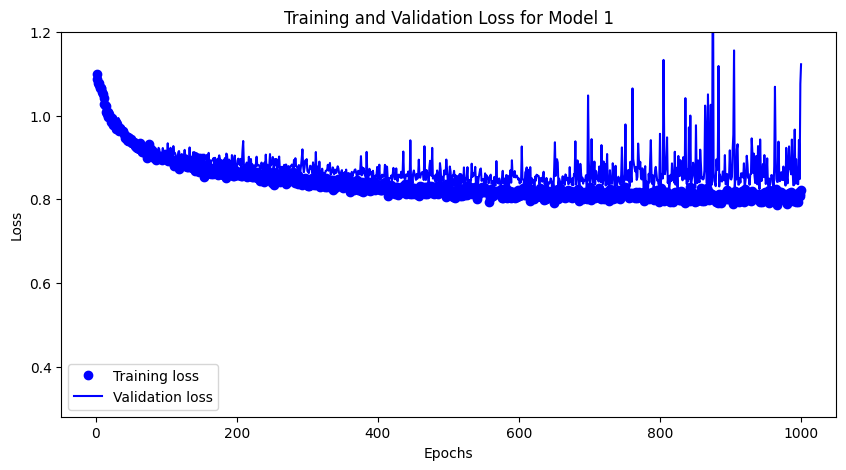

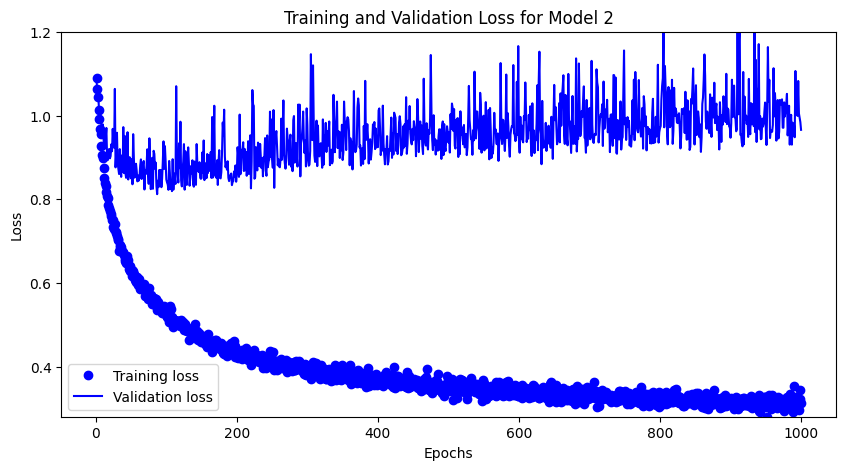

In [17]:
# Get loss and val_loss for the first model
loss1 = fittedModel.history['loss']
val_loss1 = fittedModel.history['val_loss']

# Get loss and val_loss for the second model
loss2 = fittedModel_hp.history['loss']
val_loss2 = fittedModel_hp.history['val_loss']

# Combine all loss values
all_losses = loss1 + val_loss1 + loss2 + val_loss2

# Determine the min and max values
y_min = min(all_losses)
y_max = 1.2

# Plot for the first model
epochs1 = range(1, len(loss1) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs1, loss1, 'bo', label='Training loss')
plt.plot(epochs1, val_loss1, 'b', label='Validation loss')
plt.title('Training and Validation Loss for Model 1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(y_min, y_max)
plt.legend()
plt.show()

# Plot for the second model
epochs2 = range(1, len(loss2) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs2, loss2, 'bo', label='Training loss')
plt.plot(epochs2, val_loss2, 'b', label='Validation loss')
plt.title('Training and Validation Loss for Model 2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(y_min, y_max)
plt.legend()
plt.show()


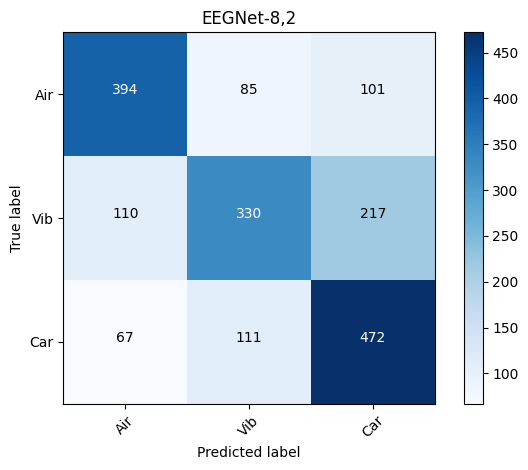

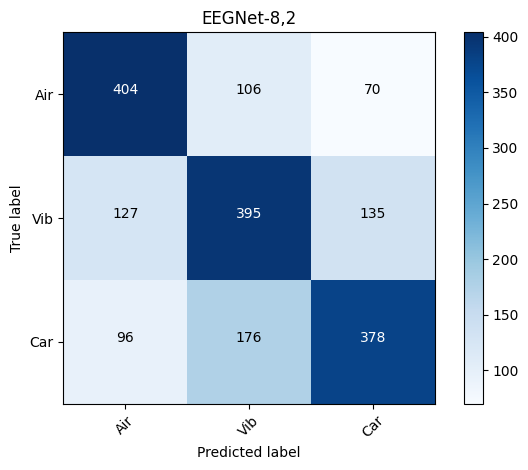

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns  # For enhanced confusion matrix visualization
import itertools  # Import itertools for product function

def plot_confusion_matrix(cm, classes, title):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = range(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Compute confusion matrices
cm1 = confusion_matrix(y_test.argmax(axis=-1), preds)
names        = ['Air', 'Vib', 'Car']

# Plot the confusion matrices
plt.figure(0)
plot_confusion_matrix(cm1, names, 'EEGNet-8,2')

plt.show()

# Compute confusion matrices
cm1 = confusion_matrix(y_test.argmax(axis=-1), preds_hp)
names        = ['Air', 'Vib', 'Car']

# Plot the confusion matrices
plt.figure(0)
plot_confusion_matrix(cm1, names, 'EEGNet-8,2')

plt.show()